In [1]:
from functions.dataProcessing import *
from functions.kernels import *
from functions.models import *
from functions.acquisitionFunctions import *
from timeit import default_timer as timer

df = readData()

In [2]:
f = open("experiment/roughEnvironment.json")
roughEnvironments = json.load(f)
f.close()
f = open("experiment/smoothEnvironment.json")
smoothEnvironments = json.load(f)
f.close()

gpPars = pd.read_csv("rationalModels/parameters/gpucb.csv", sep=",")

In [3]:
from IPython.display import clear_output

def gprDF(replications=100):
    columns = ["trial", "environment", "context", "meanReward", "meanSE"]
    gprdf = {"trial": [x for x2 in range(4) for x in range(20)],
               "environment": (["Smooth"]*20 + ["Rough"]*20)*2,
               "context": ["Conceptual"]*40 + ["Spatial"]*40,
               "meanReward": np.array([]),
               "meanSE": np.array([])}
    smoothTotal = 0
    roughTotal = 0
    choices = [[x2, x1] for x1 in range(8) for x2 in range(8)]

    for task in ["Conceptual", "Spatial"]:
        smoothPars = gpPars.loc[(gpPars["environment"] == "Smooth") & (gpPars["context"] == task)]
        roughPars = gpPars.loc[(gpPars["environment"] == "Rough") & (gpPars["context"] == task)]
        for x in range(replications):
            # Smooth
            params = smoothPars.iloc[np.random.randint(0,np.shape(smoothPars)[0]),:]
            lam = params["lambda"]
            beta = params["beta"]
            tau = params["tau"]
            envNum = np.random.randint(0,40)
            location = np.random.randint(0,64)
            x1 = [choices[location][0]]
            x2 = [choices[location][1]]
            smoothReward = [[1]]*20
            Y = [smoothEnvironments[str(envNum)][str(location)]["y"]*100]
            smoothReward[0] = Y[0]
            for i in range(19):
                j = i+1
                post = gpr(choices, [lam, lam, 1, 0.0001], np.column_stack((x1, x2)), (np.matrix(Y)-50)/100, rbf)
                utilityVec = ucb(post, [beta])
                utilityVec = utilityVec - np.max(utilityVec)
                p = np.exp(utilityVec/tau)
                p = p/np.sum(p)
                location = np.random.choice(range(64), 1, True, p.tolist()[0])[0]
                smoothReward[j] = smoothEnvironments[str(envNum)][str(location)]["y"]*100
                x1 = x1 + [choices[location][0]]
                x2 = x2 + [choices[location][1]]
                Y = Y + [smoothReward[j]]
            if x == 0 and task == "Conceptual":
                smoothTotal = smoothReward
            else:
                smoothTotal = np.column_stack((smoothTotal, smoothReward))

            # Rough
            params = roughPars.iloc[np.random.randint(0,np.shape(roughPars)[0]),:]
            lam = params["lambda"]
            beta = params["beta"]
            tau = params["tau"]
            envNum = np.random.randint(0,40)
            location = np.random.randint(0,64)
            x1 = [choices[location][0]]
            x2 = [choices[location][1]]
            roughReward = [[1]]*20
            Y = [roughEnvironments[str(envNum)][str(location)]["y"]*100]
            roughReward[0] = Y[0]
            for i in range(19):
                j = i+1
                post = gpr(choices, [lam, lam, 1, 0.0001], np.column_stack((x1, x2)), (np.matrix(Y)-50)/100, rbf)
                utilityVec = ucb(post, [beta])
                utilityVec = utilityVec - np.max(utilityVec)
                p = np.exp(utilityVec/tau)
                p = p/np.sum(p)
                location = np.random.choice(range(64), 1, True, p.tolist()[0])[0]
                roughReward[j] = roughEnvironments[str(envNum)][str(location)]["y"]*100
                x1 = x1 + [choices[location][0]]
                x2 = x2 + [choices[location][1]]
                Y = Y + [roughReward[j]]
            if x == 0 and task == "Conceptual":
                roughTotal = roughReward
            else:
                roughTotal = np.column_stack((roughTotal, roughReward))

            clear_output(wait=True)
            print(task + ": " + str(x+1) + "/" + str(replications))

        if task == "Conceptual":
            gprdf["meanReward"] = np.concatenate((smoothTotal.mean(1), roughTotal.mean(1)))
            gprdf["meanSE"] = np.concatenate((smoothTotal.std(1)/np.sqrt(np.shape(smoothTotal)[0]), roughTotal.std(1)/np.sqrt(np.shape(roughTotal)[0])))
        else:
            gprdf["meanReward"] = np.concatenate((gprdf["meanReward"], smoothTotal.mean(1), roughTotal.mean(1)))
            gprdf["meanSE"] = np.concatenate((gprdf["meanSE"], smoothTotal.std(1)/np.sqrt(np.shape(smoothTotal)[0]), roughTotal.std(1)/np.sqrt(np.shape(roughTotal)[0])))
    return gprdf

In [8]:
start = timer()
gprdf = gprDF(5)
end = timer()
print(end - start)

Spatial: 5/5
9.256953591999263


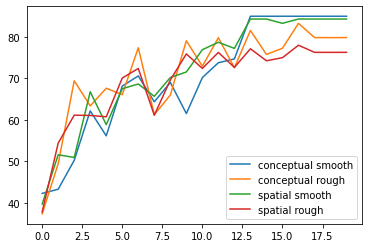

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(20),gprdf["meanReward"][0:20])
plt.plot(range(20),gprdf["meanReward"][20:40])
plt.plot(range(20),gprdf["meanReward"][40:60])
plt.plot(range(20),gprdf["meanReward"][60:80])
plt.legend(["conceptual smooth","conceptual rough","spatial smooth","spatial rough"])